# PowerPlant --> Predict PE (net hourly electrical energy output)


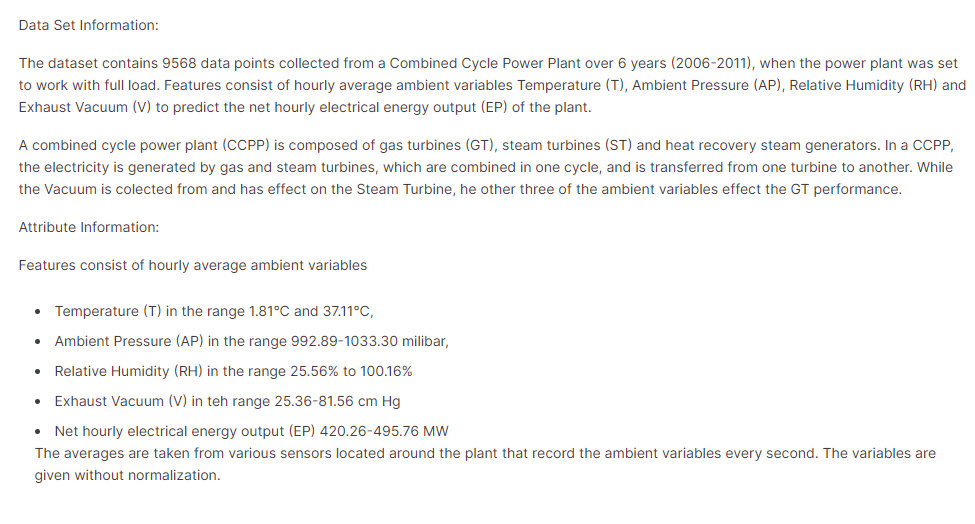

In [1]:
from warnings import filterwarnings
filterwarnings ('ignore')

## Step 1 : Read the dataset

In [2]:
import pandas as pd
df = pd.read_csv('PowerPlant.csv')
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


## Step 2: Basic data quality check

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [4]:
m = df.isna().sum()
m[m>0]

Series([], dtype: int64)

In [5]:
df.duplicated().sum()
# we ignore the duplicate rows here as there can be same temperature reading during different times 

41

## Step 3: Separate X and Y (PE - Net hourly electrical energy output)

In [6]:
X = df.drop(columns=['PE'])
Y = df[['PE']]

In [7]:
X.head()

,AT,V,AP,RH
0,8.34,40.77,1010.84,90.01
1,23.64,58.49,1011.40,74.20
2,29.74,56.90,1007.15,41.91
3,19.07,49.69,1007.22,76.79
4,11.80,40.66,1017.13,97.20


In [8]:
Y.head()

,PE
0,480.48
1,445.75
2,438.76
3,453.09
4,464.43


## Step 4: Data Preprocessing Pipeline for X

### no categorical features in X so no need to separate cat and con features for X

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
#no categrical features so no need to import OneHotEndocder


In [10]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                           ('scaler', StandardScaler())]).set_output(transform='pandas')

In [11]:
X_pre = num_pipe.fit_transform(X)
X_pre.head()

,AT,V,AP,RH
0,-1.517862,-1.065205,-0.407357,1.143944
1,0.535255,0.329277,-0.313057,0.061031
2,1.353818,0.204151,-1.028729,-2.150688
3,-0.077996,-0.363242,-1.016941,0.238434
4,-1.053562,-1.073861,0.651838,1.636427


## Step 5: Apply Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=21)

In [13]:
xtrain.head()

,AT,V,AP,RH
8710,1.555104,1.423142,-2.321990,-0.351997
6198,0.178308,-0.829119,-0.435984,-0.724612
1257,-0.523509,-1.126587,-1.050620,0.282956
4643,0.061562,-0.245199,-0.915905,1.284360
8090,-1.556777,-1.077009,0.825283,0.024728


In [14]:
ytrain.head()

,PE
8710,430.70
6198,449.88
1257,464.95
4643,449.03
8090,477.20


In [15]:
xtest.head()

,AT,V,AP,RH
6766,0.380936,0.563789,-0.693626,1.159013
4779,-0.013584,-0.965262,-0.550491,-0.372545
879,-0.867037,-1.190331,1.753131,-0.447205
5694,1.200841,0.594480,-0.235596,-0.765709
4551,0.441322,0.566150,-0.843496,0.009659


In [16]:
ytest.head()

,PE
6766,437.01
4779,466.40
879,469.62
5694,439.74
4551,445.31


In [17]:
xtrain.shape

(7654, 4)

In [18]:
xtest.shape

(1914, 4)

## Step 6: Model Building --> Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor
model1 = RandomForestRegressor(n_estimators=1,
                               max_depth=1,
                               min_samples_split=5,
                               min_samples_leaf=5,
                               criterion='squared_error')
model1.fit(xtrain, ytrain)

RandomForestRegressor(max_depth=1, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=1)

#### Acurracy in Train & Test data

In [20]:
model1.score(xtrain, ytrain)

0.7217366986184912

In [21]:
model1.score(xtest,ytest)

0.7134808118528875

## Step 7 (a): Hyperparameter Tuning-RandomForest - RandomizedSearchCV

In [22]:
params1 = {'n_estimators':[10, 50, 100, 200, 300],
           'max_depth':[2, 3, 4, 5],
           'min_samples_split':[5,6,7,8],
           'criterion':['squared_error', 'absolute_error']}

In [23]:
from sklearn.model_selection import RandomizedSearchCV
rfc = RandomForestRegressor()
rscv1 = RandomizedSearchCV(rfc, param_distributions=params1, cv=5, scoring='neg_mean_squared_error')
rscv1.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [2, 3, 4, 5],
                                        'min_samples_split': [5, 6, 7, 8],
                                        'n_estimators': [10, 50, 100, 200,
                                                         300]},
                   scoring='neg_mean_squared_error')

In [24]:
rscv1.best_params_

{'n_estimators': 100,
 'min_samples_split': 6,
 'max_depth': 5,
 'criterion': 'squared_error'}

In [25]:
rscv1.best_score_

-17.629244504771485

In [26]:
best_rfc = rscv1.best_estimator_
best_rfc

RandomForestRegressor(max_depth=5, min_samples_split=6)

In [27]:
best_rfc.score(xtrain,ytrain)

0.9427132660537417

In [28]:
best_rfc.score(xtest, ytest)

0.9415544215220238

## Step 8: Model Building and Hyperparameter Tuning-Gradient Boosting - RandomizedSearchCV

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
model2 = GradientBoostingRegressor(learning_rate=0.1,
                                   n_estimators=1,
                                   max_depth=1,
                                   min_samples_split=5,
                                   min_samples_leaf=5)
model2.fit(xtrain, ytrain)

GradientBoostingRegressor(max_depth=1, min_samples_leaf=5, min_samples_split=5,
                          n_estimators=1)

In [37]:
model2.score(xtrain, ytrain)

0.13726322298878657

In [38]:
model2.score(xtest, ytest)

0.13486853602590387

In [41]:
params2 = {'learning_rate':[0.01, 0.1, 0.15, 0.2],
           'n_estimators':[10, 50, 100, 200, 300],
           'max_depth':[2, 3, 4, 5],
           'min_samples_split':[5,6,7,8,9]}

In [42]:
gbc = GradientBoostingRegressor()
rscv2 = RandomizedSearchCV(gbc, param_distributions=params2, cv=5, scoring='neg_mean_squared_error')
rscv2.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 4, 5],
                                        'min_samples_split': [5, 6, 7, 8, 9],
                                        'n_estimators': [10, 50, 100, 200,
                                                         300]},
                   scoring='neg_mean_squared_error')

In [43]:
rscv2.best_params_

{'n_estimators': 300,
 'min_samples_split': 9,
 'max_depth': 3,
 'learning_rate': 0.15}

In [45]:
rscv2.best_score_

-12.460032718146975

In [46]:
best_gbc = rscv2.best_estimator_
best_gbc

GradientBoostingRegressor(learning_rate=0.15, min_samples_split=9,
                          n_estimators=300)

In [47]:
best_gbc.score(xtrain, ytrain)

0.9693615092291967

In [48]:
best_gbc.score(xtest, ytest)

0.9605350941204368

#### Conlusion - based on scores, Gradient Boosting performs better than Random Forest

## Step 8: Predict results for Random Forest vs Gradient Boosting

In [29]:
ypred_train1 = best_rfc.predict(xtrain)
ypred_test1 = best_rfc.predict(xtest)

In [30]:
ypred_train1[0:5]

array([432.49120096, 453.33387729, 463.33794532, 450.691232  ,
       481.7687313 ])

In [31]:
ytrain.head()

,PE
8710,430.70
6198,449.88
1257,464.95
4643,449.03
8090,477.20


In [32]:
ypred_test1[0:5]

array([445.51104986, 457.58482816, 471.35116324, 440.79050435,
       444.88722089])

In [33]:
ytest.head()

,PE
6766,437.01
4779,466.40
879,469.62
5694,439.74
4551,445.31


In [49]:
ypred_train2 = best_gbc.predict(xtrain)
ypred_test2 = best_gbc.predict(xtest)

In [50]:
ypred_train2[0:5]

array([430.11044438, 453.36569587, 464.23194429, 450.10278934,
       480.6065688 ])

In [51]:
ytrain.head()

,PE
8710,430.70
6198,449.88
1257,464.95
4643,449.03
8090,477.20


In [52]:
ypred_test2[0:5]

array([442.78164938, 460.58471927, 470.34371488, 440.82371219,
       443.74517633])

In [53]:
ytest.head()

,PE
6766,437.01
4779,466.40
879,469.62
5694,439.74
4551,445.31


## Step 9: Push this file to github

Befoe pushing save the file --> File --> Save all 

1. git add .
2. git commit -m "Practise Ensemble - PowerPlant"
3. git push -u origin main